# D(St)reams of Anomalies

Anomaly Detection Modeling - Project 4

Submitted by: Mugdha Bajjuri

The Numenta Anomaly Benchmark (NAB) is a novel benchmark for evaluating algorithms for anomaly detection in streaming, online applications. It is comprised of over 50 labeled real-world and artificial timeseries data files plus a novel scoring mechanism designed for real-time applications. All of the data and code is fully open-source, with extensive documentation, and a scoreboard of anomaly detection algorithms: github.com/numenta/NAB. 


Below Anomaly detecting models are applied on realKnownCause data ambient_temperature_system_failure.csv

##### Importing necessary libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings

from datetime import datetime

from sklearn import preprocessing
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.preprocessing import StandardScaler

from mpl_toolkits.mplot3d import axes3d, Axes3D 
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../data/raw/nab/realKnownCause/realKnownCause/ambient_temperature_system_failure.csv')
df.head()

,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 2 columns):
timestamp    7267 non-null object
value        7267 non-null float64
dtypes: float64(1), object(1)
memory usage: 113.6+ KB


### Distribution of temperature over the years

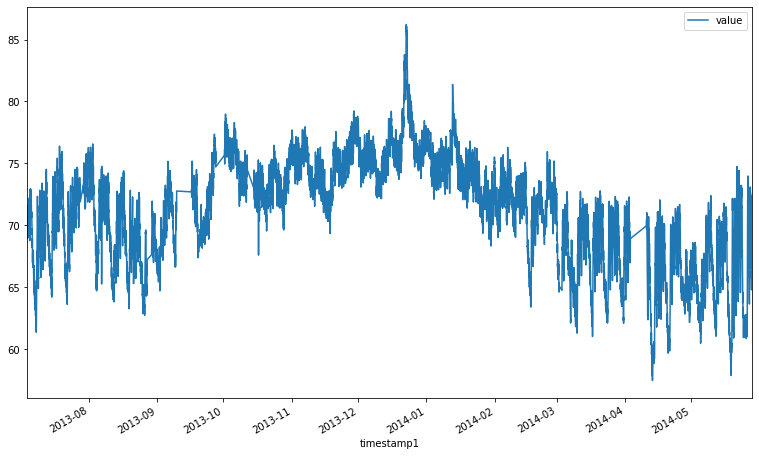

In [4]:
df['timestamp1'] = pd.to_datetime(df['timestamp'])
df.plot(x='timestamp1', y='value', figsize=(13,8))

In [5]:
range(df.shape[0])

range(0, 7267)

### temperature ranging

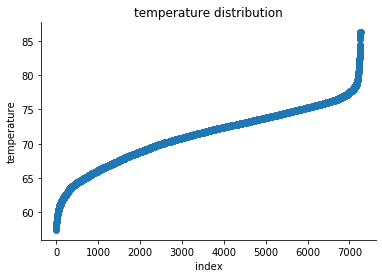

In [6]:
plt.scatter(df.index, np.sort(df['value'].values))
plt.xlabel('index')
plt.ylabel('temperature')
plt.title("temperature distribution")
sns.despine()

### Feature Engineering

Generated year, day and hour features from the timestamp data.

day_of_week gives values 0 till 6

Month and week number are also derived

For generating the feature season -->  #dec - feb is winter, then spring, summer, fall etc
0 -> winter(dec-feb) ; 1 -> Spring(mar-may) ; 2 -> Summer(jun-aug) ; 3 -> Fall(sep-nov) 

In [7]:
#reference - https://bigdatascientistblog.wordpress.com/2015/10/02/feature-engineering-with-dates-part-1/
year = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S" ).year
df['year'] = df['timestamp'].map(year)
day = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S" ).day
df['day'] = df['timestamp'].map(day)
hour = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S" ).hour
df['hour'] = df['timestamp'].map(hour)

In [8]:
day_of_week = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S" ).weekday()
#day of week starting from 0
month = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S" ).month
week_number = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S" ).strftime('%V')
df['day_of_week'] = df['timestamp'].map(day_of_week)
df['month'] = df['timestamp'].map(month)
df['week_number'] = df['timestamp'].map(week_number)

In [9]:
seasons = [0,0,1,1,1,2,2,2,3,3,3,0]
season = lambda x: seasons[(datetime.strptime(x, "%Y-%m-%d %H:%M:%S" ).month-1)]
df['season'] = df['timestamp'].map(season)

In [10]:
# sleep(0): 12-5, 6-9: breakfast(1), 10-14: lunch(2), 14-17: dinner prep(3), 17-21: dinner(4), 21-23(5): deserts!
times_of_day = [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5 ]
time_of_day = lambda x: times_of_day[datetime.strptime(x, "%Y-%m-%d %H:%M:%S").hour]
df['time_of_day'] = df['timestamp'].map(time_of_day)

In [11]:
df.head()

,timestamp,value,timestamp1,year,day,hour,day_of_week,month,week_number,season,time_of_day
0,2013-07-04 00:00:00,69.880835,2013-07-04 00:00:00,2013,4,0,3,7,27,2,0
1,2013-07-04 01:00:00,71.220227,2013-07-04 01:00:00,2013,4,1,3,7,27,2,0
2,2013-07-04 02:00:00,70.877805,2013-07-04 02:00:00,2013,4,2,3,7,27,2,0
3,2013-07-04 03:00:00,68.959400,2013-07-04 03:00:00,2013,4,3,3,7,27,2,0
4,2013-07-04 04:00:00,69.283551,2013-07-04 04:00:00,2013,4,4,3,7,27,2,0


In [12]:
#extracted features are year, day, hour, day_of_week, month, week_number, season and time_of_day

## Modeling 
### Isolation Forest

In [13]:
data = df[['value','day', 'day_of_week']]
from sklearn.ensemble import IsolationForest
clf=IsolationForest( n_estimators=100, max_samples='auto', contamination=0.05, \
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)
clf.fit(data[data.columns])
pred = clf.predict(data[data.columns])
data['anomaly']=pred
outliers=data.loc[data['anomaly']==-1]
outlier_index=list(outliers.index)
data['anomaly'] = data['anomaly'].map( {1: 0, -1: 1} )
print(data['anomaly'].value_counts())

0    6903
1     364
Name: anomaly, dtype: int64


### Visualisation of anomalies

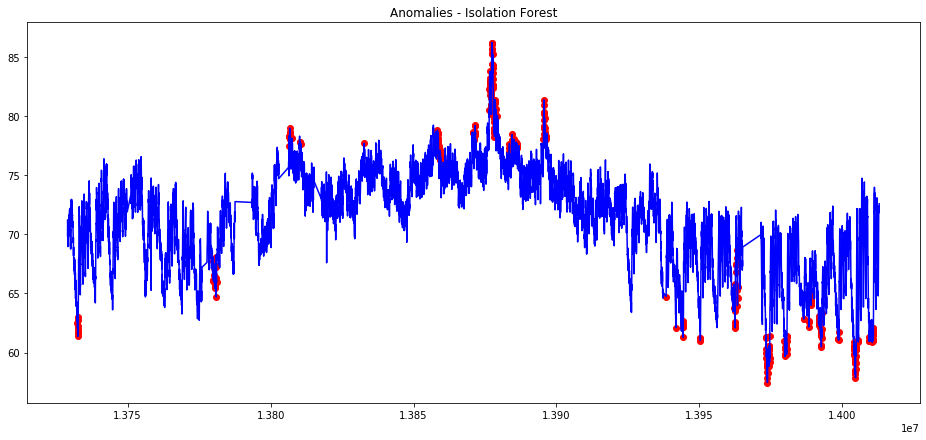

In [14]:
fig, ax = plt.subplots()

df['Time'] = (df['timestamp1'].astype(np.int64)/100000000000).astype(np.int64)

a = df.loc[data['anomaly'] == 1, ['Time', 'value']] #anomaly

fig.set_size_inches(16,7)
ax.plot(df['Time'], df['value'], color='blue')
ax.scatter(a['Time'],a['value'], color='red')
plt.title("Anomalies - Isolation Forest")
plt.show()

#### visualisation of anomaly with temperature repartition

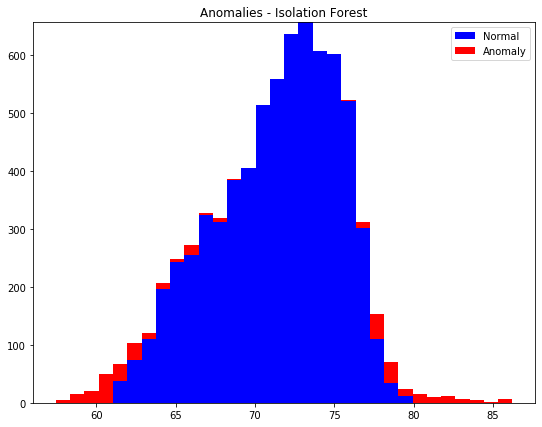

In [15]:
a = df.loc[data['anomaly'] == 0, 'value']
b = df.loc[data['anomaly'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label = ['Normal', 'Anomaly'])
fig.set_size_inches(9,7)
plt.title("Anomalies - Isolation Forest")
plt.legend()
plt.show()

## Anomoly Visualization in 3D

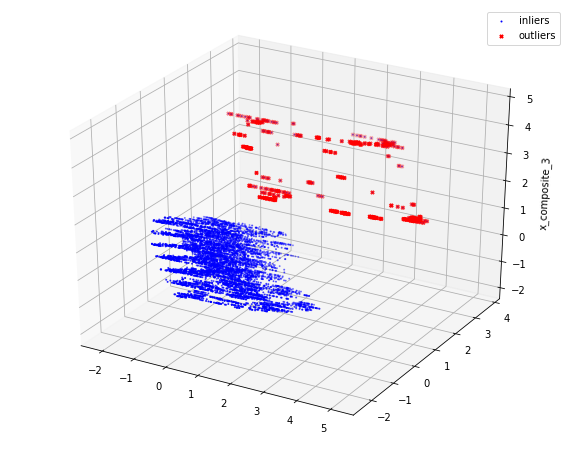

In [16]:
pca = PCA(n_components=3) 
min_max_scaler = StandardScaler()
np_scaled = min_max_scaler.fit_transform(data[data.columns])
model = pca.fit_transform(np_scaled)
fig = plt.figure(figsize=(10, 8))
#fig.size = (12,8)
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")
ax.scatter(model[:, 0], model[:, 1], zs=model[:, 2], s=1, lw=1, label="inliers",c="blue")
ax.scatter(model[outlier_index,0],model[outlier_index,1], model[outlier_index,2],
           lw=2, s=10, marker="x", c="red", label="outliers")
ax.legend()
plt.show()

## One class SVM

In [17]:
#svm
from sklearn.svm import OneClassSVM
data = df[['value','day', 'day_of_week']]
from sklearn.ensemble import IsolationForest
clf=OneClassSVM(nu=0.95 * 0.05)
clf.fit(data[data.columns])
pred = clf.predict(data[data.columns])
data['anomaly']=pred
outliers=data.loc[data['anomaly']==-1]
outlier_index=list(outliers.index)
data['anomaly'] = data['anomaly'].map( {1: 0, -1: 1} )
print(data['anomaly'].value_counts())

0    6389
1     878
Name: anomaly, dtype: int64


## VIsualization in 3D

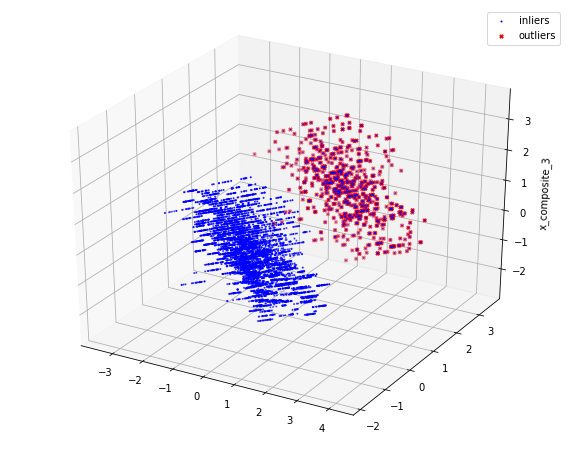

In [18]:
pca = PCA(n_components=3) 
min_max_scaler = StandardScaler()
np_scaled = min_max_scaler.fit_transform(data[data.columns])
model = pca.fit_transform(np_scaled)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")
ax.scatter(model[:, 0], model[:, 1], zs=model[:, 2], s=1, lw=1, label="inliers",c="blue")
ax.scatter(model[outlier_index,0],model[outlier_index,1], model[outlier_index,2],
           lw=2, s=10, marker="x", c="red", label="outliers")
ax.legend()
plt.show()

#### Observation

- It can be seen that One class SVM performed better over the Isolation forest
- Also By observing the graphs it is evident that system failure happened on:
    - First Anomoly might have happened on 2014 January 
    - Second Anomoly might have happened on 2014-mid of April
    - Third Anomoly might have happened on 2014 mid of may
